# Amazon Fine Food Reviews Analysis:



## Loading the data


In [2]:
import pandas as pd
import numpy as np
import nltk
import string
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3,as we can't be sure about the polarity of the reviews with Score 3.
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [4]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
filtered_data_copy=filtered_data.copy()

 #  Exploratory Data Analysis

##  Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
dup=filtered_data.duplicated(subset=['ProductId','UserId','Time','HelpfulnessNumerator','HelpfulnessDenominator','Score','Text'],keep=False)

In [7]:
filtered_data.loc[dup,:].shape

(718, 10)

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
After_dedup=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text",'HelpfulnessNumerator','HelpfulnessDenominator','Score'}, keep='first', inplace=False)
print(After_dedup.shape)

(365910, 10)


In [10]:
dup1=After_dedup.duplicated(subset=["UserId","ProfileName","Time","Text"],keep=False)


In [11]:
After_dedup.loc[dup1,:].shape

(3067, 10)

In [12]:
#Sorting data according to ProductId in ascending order
sorted_After_dedup_data=After_dedup.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [13]:
#Again Deduplication of entries
After_dedup=sorted_After_dedup_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(After_dedup.shape)

(364173, 10)


In [14]:
#Checking to see how much % of data still remains
((After_dedup['Id'].size)*1.0)/((filtered_data['Id'].size)*1.0)*100

69.25890143662969

Observation: Again it's found that for the below 2 Users the HelpfulnessNumerator is greater than HelpfulnessDenominator.But it is practically not possible,so they need to be removed as well.

In [15]:
After_dedup[After_dedup.HelpfulnessNumerator>After_dedup.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [16]:
After_dedup=After_dedup[After_dedup.HelpfulnessNumerator<=After_dedup.HelpfulnessDenominator]

In [17]:
After_dedup.shape

(364171, 10)

In [18]:
# Now let's see the Positive and Negetive Scores in our dataset:

In [19]:
After_dedup['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [21]:
Prob=After_dedup[After_dedup['Score']=='positive'].size/(After_dedup[After_dedup['Score']=='negative'].size+After_dedup[After_dedup['Score']=='positive'].size)

In [22]:
print("The Probability of Positive Score :",Prob)

The Probability of Positive Score : 0.843178067446337


# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [23]:
# find sentences containing HTML tags
import re
i=0;
for sent in After_dedup['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

2
In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# Faced a Problem Fetching the stopwords,hence from nltk library stopwords needed to be downloaded.

In [26]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"weren't", 'by', "aren't", "isn't", 'what', 'm', 'y', "wasn't", 'at', 'you', 'its', "doesn't", 'under', "should've", "that'll", 'same', 'and', 'am', 'why', 'itself', 'we', 'that', 'yourselves', 'myself', 'off', 'will', 'no', 'mustn', 'some', 'down', 'she', 'yours', 'he', 'their', 'was', 'during', 'each', "she's", 'do', 'themselves', 'these', 'above', 'too', 'are', 'wasn', 'doing', "won't", 'couldn', 'the', 'on', 'in', 'a', 'before', 'to', 'doesn', 'ain', 'with', "mustn't", "you've", 're', 'up', 'not', 'below', "didn't", 'just', 'between', 'didn', 'having', 'very', 'won', 'can', 'an', "it's", 'my', 'd', 'it', 'your', 'll', "hadn't", 'had', 'his', 'if', 'there', 'because', 'them', 'weren', 'they', 'have', 'after', 'as', "haven't", 'don', 'mightn', "shouldn't", 'other', 'me', "don't", 'where', 'o', 'against', 'yourself', 'haven', 'through', "hasn't", "you'd", 'did', 'of', 'which', 'such', "shan't", 'being', 'shouldn', 'been', 'when', 'both', 'from', 'does', 'ourselves', "you're", 'hadn',

In [27]:
stop.remove('not') #Actually before eliminating Stopwords,'not' as stopword must me removed before applying BoW technique.
                   # After removing 'not' again executing the code the KeyError is 'not',as it is not in set.

In [29]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in After_dedup['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (After_dedup['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(After_dedup['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [30]:
After_dedup['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
After_dedup['CleanedText']=After_dedup['CleanedText'].str.decode("utf-8")

In [31]:
After_dedup.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('After_dedup.sqlite')
c=conn.cursor()
conn.text_factory = str
After_dedup.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Bag of Words (BoW)

In [32]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(After_dedup['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 71625)
the number of unique words  71625


#  Bi-Grams and n-Grams.


Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [33]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'not', 146797), (b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715)]
Most Common Negative Words :  [(b'not', 54378), (b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'not' could be used as 'not costly','not so bad' etc.But it arrises ambiguity as well. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or sequnce of n consecutive words (n-grams)

In [34]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(After_dedup['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 2905338)
the number of unique words including both unigrams and bigrams  2905338


#  TF-IDF

In [35]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(After_dedup['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 2905338)
the number of unique words including both unigrams and bigrams  2905338


In [36]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

some sample features(unique words in the corpus) ['anyhow bare', 'anyhow big', 'anyhow bit', 'anyhow blend', 'anyhow bought', 'anyhow brew', 'anyhow brought', 'anyhow buy', 'anyhow call', 'anyhow cat']


In [37]:
final_tf_idf_data=final_tf_idf[:500,:500]

In [38]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

#  Word2Vec

In [40]:
# Train your own Word2Vec model using own text corpus
i=0
list_of_sent=[]
for sent in After_dedup['CleanedText'].values:
    list_of_sent.append(sent.split())

In [42]:
print(After_dedup['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [43]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [44]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  21939
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'one', 'best', 'children', 'ever', 'written', 'mini', 'version', 'not', 'portray', 'price', 'product', 'sent', 'email', 'regard', 'amazon', 'got', 'respons', 'june', 'saw']


In [47]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
print(count_vect_feat[count_vect_feat.index('like')])

like


#  Avg W2V

In [48]:
# average Word2Vec
# computing average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

364171
50


# Decision Tree Classification on Tf-IDF Data :

In [49]:
After_dedup.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children book ever written mini versi...
138709,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,positive,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,june saw charm group rose begin droop pep chic...
138699,150517,0006641040,ABW4IC5G5G8B5,kevin clark,0,0,positive,1291075200,good for children,"Classic children's book, can't go wrong. I rea...",classic children book cant wrong read kid orde...
138686,150504,0006641040,AQEYF1AXARWJZ,"Les Sinclair ""book maven""",1,1,positive,1212278400,Chicken Soup with Rice,A very entertaining rhyming story--cleaver and...,entertain rhyme catchi illustr imagin fit righ...


In [50]:
from sklearn.model_selection import train_test_split

In [51]:
y=After_dedup["Score"].iloc[:500]

In [52]:
x_train,x_test,y_train,y_test=train_test_split(final_tf_idf_data,y,test_size=0.2,random_state=2)

In [109]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import scorer,roc_auc_score,f1_score,precision_score,recall_score

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

Hyperparameter Tuning:Finding Max-Depth with Crossvalidation Accuracy and Crossvalidation Error plot.

In [123]:
tr=DecisionTreeClassifier()
print("Cross-validation Scores:")
scores = cross_val_score(tr, x_train, y_train,scoring='roc_auc_score', cv=20)
print(scores)


Cross-validation Scores:
[0.85714286 0.85714286 0.85       0.85       0.85       0.85
 0.85       0.85       0.85       0.85       0.85       0.85
 0.85       0.85       0.85       0.85       0.85       0.85
 0.89473684 0.89473684]


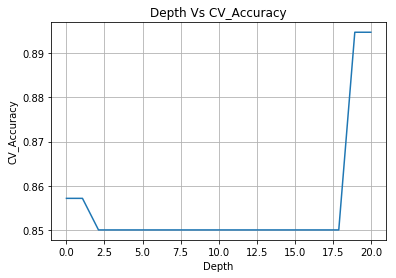

In [125]:
plt.plot(depths,scores)
plt.grid()
plt.title("Depth Vs CV_Accuracy")
plt.xlabel("Depth")
plt.ylabel("CV_Accuracy")
plt.show()


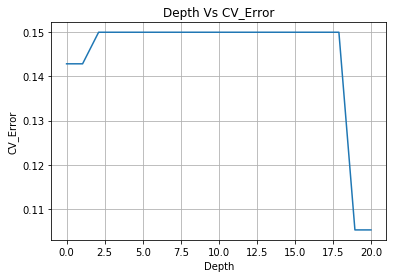

In [126]:
cv_error=1-scores
plt.plot(depths,cv_error)
plt.grid()
plt.title("Depth Vs CV_Error")
plt.xlabel("Depth")
plt.ylabel("CV_Error")
plt.show()

Hence From these two graphs it is clear that, at Max-depth=19, the Accuracy is achieving Highest for the first time,also the error is declined to it's lowest point at Max-depth=19.

In [136]:
parameters={'criterion':['gini','entropy'],'max_depth':[13,15,17,19]}

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score

In [164]:
tr=DecisionTreeClassifier()
gsearch = GridSearchCV(tr,parameters,cv=20)
gr=gsearch.fit(x_train, y_train)
model = gsearch.best_estimator_
print(model)
print("\n\n")
print("GridSearch cross-validation Results:")
#print(gsearch.cv_results_)
print("\n\n")
print("Cross-validation Scores:")
scores = cross_val_score(model, x_train, y_train,scoring='roc_auc_score',cv=20)
print(scores)
model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')



GridSearch cross-validation Results:



Cross-validation Scores:
[0.85714286 0.85714286 0.85       0.85       0.85       0.85
 0.85       0.85       0.85       0.85       0.85       0.85
 0.85       0.85       0.85       0.85       0.85       0.85
 0.89473684 0.89473684]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [165]:
score=model.score(x_test,y_test)
print("The Accuracy on Test/Unknown data is:",score)

The Accuracy on Test/Unknown data is: 0.85


In [140]:
w=tf_idf_vect.get_feature_names()

In [141]:
coeff_df = pd.DataFrame({'Word' : w})
coeff_df = coeff_df.sort_values(['Word'], ascending=[0])
print('')
print('-Top 25 positive-')
print(coeff_df.head(25).to_string(index=False))


-Top 25 positive-
Word
                                       îts real
                                            îts
                                      île would
                                            île
                                      être fort
                                           être
                                  çelem ferment
                                          çelem
                                     çaykur tea
                                         çaykur
                                            çay
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz usual
      zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz
                                    zzzzzzzzzzz
                               zzzzzzzzzz final
                                     zzzzzzzzzz
                                       zzzzzzzz
                                   zzzzzzz high
                                        zzzzzzz
                                     zzzzzz say
                

In [142]:
print('-Top 25 negetive-')
print(coeff_df.tail(25).to_string(index=False))

-Top 25 negetive-
Word
                          aaaaaaaaaaaaaaaaaaaargh
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa s...
     aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
            aaaaaaaaaaaaaa hahahahhahahaahhahaaha
                                   aaaaaaaaaaaaaa
                                      aaaaa start
                                        aaaaa kid
                                            aaaaa
                                             aaaa
                                          aaa tue
                                        aaa spelt
                                         aaa rate
                                         aaa plus
                                      aaa perfect
                                      aaa magazin
                                          aaa job
                                       aaa hockey
                                         aaa dont
                                       aaa condit
                           

In [144]:
#model
gsearch.fit(x_train,y_train)
predictions   = gsearch.predict(x_test)
probabilities = gsearch.predict_proba(x_test)

In [145]:
print ("\n Classification report : \n",classification_report(y_test,predictions))
print ("Accuracy   Score : ",roc_auc_score(y_test,predictions))


 Classification report : 
              precision    recall  f1-score   support

   negative       0.00      0.00      0.00        15
   positive       0.85      1.00      0.92        85

avg / total       0.72      0.85      0.78       100

Accuracy   Score :  0.85


In [146]:
#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)


In [147]:
conf_matrix

array([[ 0, 15],
       [ 0, 85]], dtype=int64)

Result Of Confusion Matrix:

# Decision Tree Classification on AVG W2V Data:

In [149]:
import numpy as np

In [150]:
sentence_W2V=np.array(sent_vectors)

In [151]:
sentence_W2V1=sentence_W2V[:500,:]

In [152]:
X_train,X_test,Y_train,Y_test=train_test_split(sentence_W2V1,y,test_size=0.2,random_state=2)


In [160]:
print("\n\n")
scores = cross_val_score(tr, X_train, Y_train, cv=20)
print(scores)





[0.85714286 0.71428571 0.75       0.8        0.75       0.85
 1.         1.         0.75       0.85       0.8        0.85
 0.8        0.85       0.9        0.85       0.8        0.9
 0.89473684 0.78947368]


In [161]:
depths=np.linspace(0,20,20)
depths.shape

(20,)

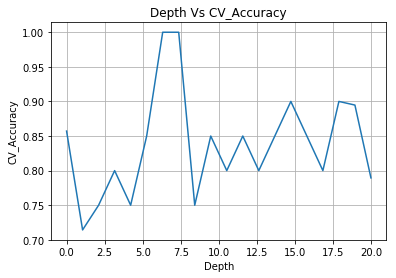

In [162]:
plt.plot(depths,scores)
plt.grid()
plt.title("Depth Vs CV_Accuracy")
plt.xlabel("Depth")
plt.ylabel("CV_Accuracy")
plt.show()

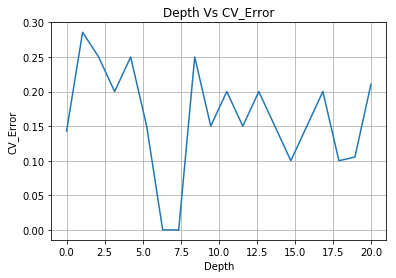

In [163]:
cv_error=1-scores
plt.plot(depths,cv_error)
plt.grid()
plt.title("Depth Vs CV_Error")
plt.xlabel("Depth")
plt.ylabel("CV_Error")
plt.show()

Hence Depth=6 is giving highest accuracy and lowest error in terms of cross validation

In [198]:
parameters={'criterion':['gini','entropy'],'max_depth':[6]}

In [199]:
tr=DecisionTreeClassifier()
gsearch = GridSearchCV(tr,parameters,cv=5)
gr=gsearch.fit(X_train, Y_train)
model = gsearch.best_estimator_
print(model)
print("\n\n")
print("GridSearch cross-validation Results:")
#print(gsearch.cv_results_)
print("\n\n")
print("Cross-validation Scores:")
scores = cross_val_score(model, X_train, Y_train,scoring='roc_auc_score', cv=5)
print(scores)
model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')



GridSearch cross-validation Results:



Cross-validation Scores:
[0.82716049 0.85185185 0.825      0.82278481 0.87341772]


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [201]:
score=model.score(X_test,Y_test)
print("The Accuracy on Test/Unknown data is:",score)

The Accuracy on Test/Unknown data is: 0.77


In [202]:
#model
gsearch.fit(X_train,Y_train)
predictions   = gsearch.predict(X_test)
probabilities = gsearch.predict_proba(X_test)

In [203]:
conf_matrix = confusion_matrix(Y_test,predictions)
print(conf_matrix)

[[ 4 11]
 [10 75]]


# Conclusion:

Decision Tree Classification on AVG W2V Data:

1.The Model is classifying 4 and 10 TN,FN cases respectively.It classifies TN cases also 4 cases also,that is Positive classification.
2.Also No of FP cases=11 and No of True Positive cases =75,which may seem moderate result.
3.Here,Probability of Positive setiment is higher(Approx 85%),as we have seen earlier,but the15% Negetives are classified wrongly.

 Decision Tree Classification on Tf-IDF Data :

1.The Model is not classifying any TN,FN cases.It classifies FP,TP cases only.<br>
2.Also No of FP cases=15 and No of True Positive cases =85,which may seem moderately good result.<br>
3.Though,TP cases are predicting all positive cases(Approx 85%),but the15% Negetives are classified wrongly.